In [1]:
!pip install torch
!pip install  pandas
!pip install pandas
!pip install torch
!pip install dgl

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#data loader and preprocessing :

In [3]:
# we have a DataFrame ASSIGNMENT 2 375_1651.docx
df1 = pd.read_csv("Final_InteractionsInfo3.csv")
df2 = pd.read_csv("FinalDataset 2.csv")

In [4]:
df1

,dg_id,dg_name_x,dg_state,SideEffect-ID,Freq-No,SideEffect,indication-ID,indication_name,Unique_Drugs_Count
0,DB00001,Lepirudin,solid,NaN,NaN,NaN,NaN,NaN,NaN
1,DB00002,Cetuximab,liquid,NaN,NaN,NaN,NaN,NaN,NaN
2,DB00003,Dornase alfa,liquid,NaN,NaN,NaN,NaN,NaN,NaN
3,DB00004,Denileukin diftitox,liquid,NaN,NaN,NaN,NaN,NaN,NaN
4,DB00005,Etanercept,liquid,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
49974,DB16862,Indigo,solid,NaN,NaN,NaN,NaN,NaN,NaN
49975,DB16900,Betibeglogene autotemcel,liquid,NaN,NaN,NaN,NaN,NaN,NaN
49976,DB17080,KW-6356,liquid,NaN,NaN,NaN,NaN,NaN,NaN
49977,DB17083,Linzagolix,solid,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df2

,Drug_ID,SideEffect_ID,L/P_x,SideEffect,Drug_Name,Drugbank_id_x,Indications_ID,Indications_Name,L/P_y,Drugbank_id_y,dg_interactions
0,CID100003425,C0000737,PT,Gastrointestinal pain,Romidepsin,CID100003425,C0009450,Communicable Diseases,PT,DB06176,DB00745;DB06413;DB00243;DB09046;DB02546;DB0068...
1,CID100003425,C0002871,PT,Anaemia,Romidepsin,CID100003425,C0009450,Communicable Diseases,PT,DB06176,DB00745;DB06413;DB00243;DB09046;DB02546;DB0068...
2,CID100003425,C0003123,PT,Decreased appetite,Romidepsin,CID100003425,C0009450,Communicable Diseases,PT,DB06176,DB00745;DB06413;DB00243;DB09046;DB02546;DB0068...
3,CID100003425,C0004093,PT,Asthenia,Romidepsin,CID100003425,C0009450,Communicable Diseases,PT,DB06176,DB00745;DB06413;DB00243;DB09046;DB02546;DB0068...
4,CID100003425,C0006826,PT,Neoplasm malignant,Romidepsin,CID100003425,C0009450,Communicable Diseases,PT,DB06176,DB00745;DB06413;DB00243;DB09046;DB02546;DB0068...
...,...,...,...,...,...,...,...,...,...,...,...
686,CID125077993,C0877303,PT,Procedural pain,Histrelin,CID125077993,C0001627,Congenital adrenal hyperplasia,PT,DB06788,DB09066;DB09277;DB00089;DB00030;DB00046;DB0004...
687,CID125077993,C0919560,PT,Device occlusion,Histrelin,CID125077993,C0001627,Congenital adrenal hyperplasia,PT,DB06788,DB09066;DB09277;DB00089;DB00030;DB00046;DB0004...
688,CID125077993,C1142470,PT,Suture related complication,Histrelin,CID125077993,C0001627,Congenital adrenal hyperplasia,PT,DB06788,DB09066;DB09277;DB00089;DB00030;DB00046;DB0004...
689,CID125077993,C1504578,PT,Device breakage,Histrelin,CID125077993,C0001627,Congenital adrenal hyperplasia,PT,DB06788,DB09066;DB09277;DB00089;DB00030;DB00046;DB0004...


In [6]:
# Retain only 'colid' and 'col2_new' columns from df2
df2 = df2.loc[:, ['Drugbank_id_y', 'dg_interactions']]

In [7]:
df2.drop_duplicates(subset='Drugbank_id_y', keep='first', inplace=True)
df = pd.merge(df1, df2, left_on='dg_id', right_on='Drugbank_id_y', how='left')

In [8]:
print(df['Freq-No'].isna().sum())

19976


In [9]:
# Calculate the mean of 'Freq-No' where 'SideEffect' is not null
mean_value = df[df['SideEffect'].notnull()]['Freq-No'].mean()

# Fill missing values in 'Freq-No' with the calculated mean, only for rows where 'SideEffect' is not null
df.loc[df['SideEffect'].notnull(), 'Freq-No'] = df.loc[df['SideEffect'].notnull(), 'Freq-No'].fillna(mean_value)

In [10]:
# node features
df['dg_state'] = df['dg_state'].map({'liquid': 1, 'solid': 0,'gas':0.5})
drug_features = df['dg_state']

#DATA PREPARATION FOR HETEROGRAPH CONSTRUCTION:

This block of code focuses on preparing and processing the dataset to construct a heterogeneous graph (often referred to as a heterograph). In a heterograph, there are multiple types of nodes and edges, which contrasts to a traditional homogeneous graph where all nodes and edges are of one type.

1. **Data Cleaning:**
    - Convert 'dg_id' and 'dg_interactions' columns to string types.
    - NaN values will be dropped where necessary.

2. **Node Identification:**
    - Unique drug nodes are identified using both 'dg_id' and 'dg_interactions' columns.
    - Unique side effect nodes and indication nodes are identified using 'SideEffect-ID' and 'indication-ID' columns, respectively.

3. **Initialize Empty Heterograph:**
    - This heterograph will consist of three types of nodes: drug, side effect, and indication.
    - Moreover, there will be three types of relationships (edges) in the graph:
        a) drug-drug interactions (dg_interactions)
        b) drug-side effect relationships (has)
        c) drug-indication relationships (treat)

4. **Aggregate Node Features:**
    - For drug nodes, the 'dg_state' feature is averaged.
    - For side effect nodes, the 'Freq-No' feature is averaged.
    - For indication nodes, the 'Unique_Drugs_Count' feature is averaged.

5. **Convert Features to Tensors:**
    - Node features are converted to tensors, ensuring compatibility with graph neural network frameworks like DGL.

6. **Incorporate Features into the Graph:**
    - The aggregated feature tensors are assigned to their respective node types in the heterograph.

7. **Construct Edges for the Heterograph**:
    - Drug-drug interaction edges are added based on the 'dg_interactions' column.
    - Drug-side effect edges are added based on the 'SideEffect-ID' column.
    - Drug-indication edges are added based on the 'indication-ID' column.

By the end of this block, a fully constructed heterograph 'g' is available with nodes and edges representing drugs, side effects, and indications in the dataset. This graph can then be used for further analysis or modeling using graph neural networks.


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import dgl
from sklearn.metrics import roc_auc_score

# Convert to string and then drop NaN values
df['dg_id'] = df['dg_id'].astype(str)
df['dg_interactions'] = df['dg_interactions'].astype(str)

# Collect unique drug IDs from both 'dg_id' and 'dg_interactions' columns.
all_drugs = np.concatenate((df['dg_id'].dropna().unique(),
                             df['dg_interactions'].str.split(';').explode().dropna().unique()))
drug_nodes = np.unique(all_drugs)

# Extract unique nodes for side effects and indications.
side_effect_nodes = df['SideEffect-ID'].dropna().unique()
indication_nodes = df['indication-ID'].dropna().unique()

# Initialize the heterograph
g = dgl.heterograph({
    ('drug', 'dg_interactions', 'drug'): ([], []),
    ('drug', 'has', 'side_effect'): ([], []),
    ('drug', 'treat', 'indication'): ([], [])
})

# Add nodes
g.add_nodes(len(drug_nodes), ntype='drug')
g.add_nodes(len(side_effect_nodes), ntype='side_effect')
g.add_nodes(len(indication_nodes), ntype='indication')

# Construct the Feature Tensors
drug_features = df.groupby('dg_id').agg({'dg_state': 'mean'}).reindex(drug_nodes).fillna(0)
side_effect_features = df.groupby('SideEffect-ID').agg({'Freq-No': 'mean'}).reindex(side_effect_nodes).fillna(0)
indication_features = df.groupby('indication-ID').agg({'Unique_Drugs_Count': 'mean'}).reindex(indication_nodes).fillna(0)

node_features = {
    'drug': torch.tensor(drug_features[['dg_state']].values, dtype=torch.float32),
    'side_effect': torch.tensor(side_effect_features[['Freq-No']].values, dtype=torch.float32),
    'indication': torch.tensor(indication_features[['Unique_Drugs_Count']].values, dtype=torch.float32)
}

# Add features to nodes in the graph
for ntype, features in node_features.items():
    g.nodes[ntype].data['feat'] = features

# Process edges
df_interactions = df.assign(interactions=df['dg_interactions'].str.split(';')).explode('interactions')
src_drug = df_interactions['dg_id'].map({drug: i for i, drug in enumerate(drug_nodes)}).dropna().values
dst_drug = df_interactions['interactions'].map({drug: i for i, drug in enumerate(drug_nodes)}).dropna().values
g.add_edges(src_drug, dst_drug, etype=('drug', 'dg_interactions', 'drug'))

src_side_effects = df.dropna(subset=['SideEffect-ID'])['dg_id'].map({drug: i for i, drug in enumerate(drug_nodes)}).dropna().values
dst_side_effects = df.dropna(subset=['SideEffect-ID'])['SideEffect-ID'].map({se: i for i, se in enumerate(side_effect_nodes)}).dropna().values
g.add_edges(src_side_effects, dst_side_effects, etype=('drug', 'has', 'side_effect'))

src_indications = df.dropna(subset=['indication-ID'])['dg_id'].map({drug: i for i, drug in enumerate(drug_nodes)}).dropna().values
dst_indications = df.dropna(subset=['indication-ID'])['indication-ID'].map({ind: i for i, ind in enumerate(indication_nodes)}).dropna().values
g.add_edges(src_indications, dst_indications, etype=('drug', 'treat', 'indication'))


**Training & Validation Split:** Here, you split your training data into training and validation sets. The idea is to shuffle your dataset randomly and then take the first 80% as your training set, and the remaining 20% as your validation set.

**Positive & Negative Samples:** Positive samples are actual drug-indication pairs in your data. To form negative samples, you randomly pair drugs and indications that aren't connected in your graph. You then concatenate these positive and negative samples to form your training data.


In [12]:
# Positive samples
pos_u, pos_v = g.edges(etype=('drug', 'treat', 'indication'))
pos_labels = torch.ones(len(pos_u))

# Negative samples
all_drugs = g.nodes('drug').data
all_indications = g.nodes('indication').data
neg_u = torch.randint(0, len(all_drugs), (len(pos_u),))
neg_v = torch.randint(0, len(all_indications), (len(pos_u),))
neg_labels = torch.zeros(len(pos_u))

# Combine positive and negative samples
train_u = torch.cat([pos_u, neg_u])
train_v = torch.cat([pos_v, neg_v])
labels = torch.cat([pos_labels, neg_labels])

# Splitting data into Training and Validation sets
split_ratio = 0.8
num_samples = len(train_u)
permuted_indices = torch.randperm(num_samples)
train_indices = permuted_indices[:int(split_ratio * num_samples)]
val_indices = permuted_indices[int(split_ratio * num_samples):]

train_u, val_u = train_u[train_indices], train_u[val_indices]
train_v, val_v = train_v[train_indices], train_v[val_indices]
train_labels, val_labels = labels[train_indices], labels[val_indices]

assert len(train_u) == len(train_labels)
assert len(train_v) == len(train_labels)

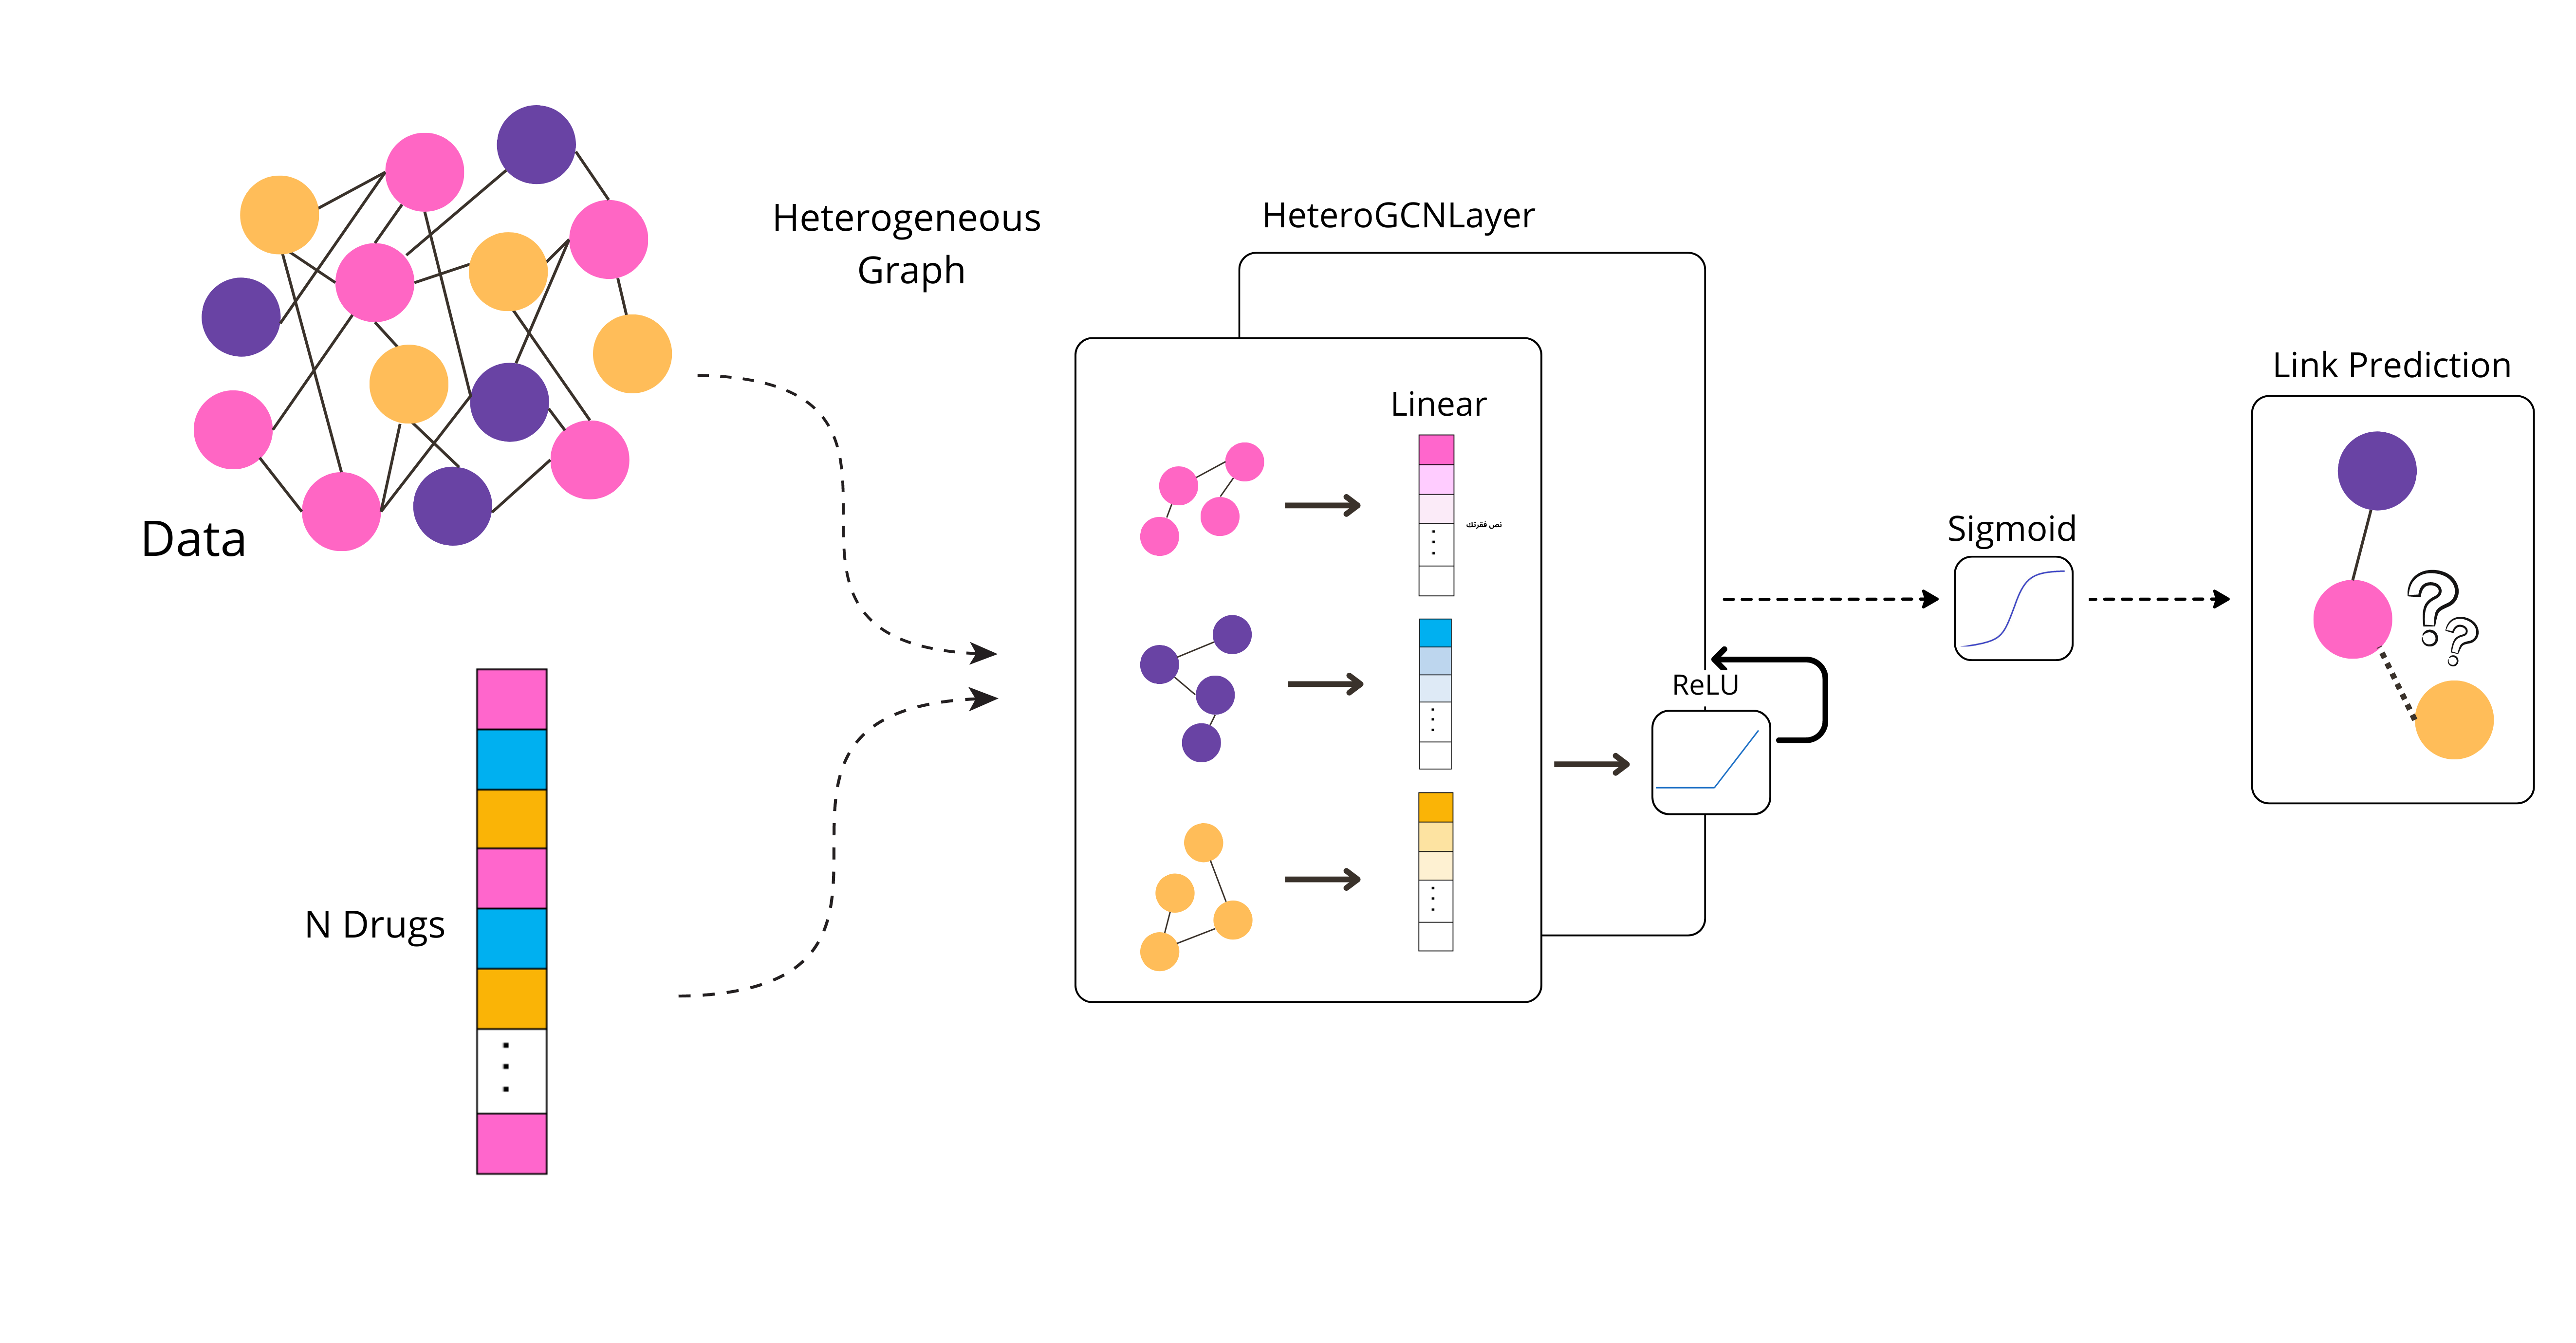

**Module**:
 the current model is a starting point. As with all deep learning models, there's always room for expansion, experimentation, and improvement based on the specific task and available data.

.  **HeteroGCNLayer**: This custom layer performs the fundamental operations of the Heterogeneous Graph Convolutional Network. For each type of edge in your graph, this layer applies a separate linear transformation to the features of the source nodes. It then aggregates the transformed features of the neighboring nodes using a mean function.

. **HeteroGCN**: This is your main model for node embeddings. It stacks two  HeteroGCNLayers sequentially, with a ReLU activation function in between.

. **LinkPredict**: This model predicts whether a link exists between two nodes based on their embeddings. You concatenate the embeddings of both nodes and pass them through a linear layer followed by a sigmoid activation. This gives you a probability between 0 and 1 indicating the likelihood of a link existing.

. **Model Initialization & Optimizer:**Here, you initialize both the HeteroGCN and LinkPredict models. The Adam optimizer is chosen to train the parameters of both models.




In [13]:

# we got variation in results because randomization so we will add random.seed 
#try diffrent number until you got the best results 42 it is just random number
import random
random.seed(42)
# Hyperparameters
hidden_size = 64  
num_layers = 3  
learning_rate = 0.01
weight_decay = 1e-4
num_epochs = 150  

#1. HeteroGCNLayer
class HeteroGCNLayer(nn.Module):
    def __init__(self, in_size, out_size, dropout_prob):
        super(HeteroGCNLayer, self).__init__()
        # Define a linear layer and a dropout layer for each edge type
        self.layers = nn.ModuleDict({
            'dg_interactions': nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.Dropout(dropout_prob)
            ),
            'has': nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.Dropout(dropout_prob)
            ),
            'treat': nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.Dropout(dropout_prob)
            )
        })

    def forward(self, g, feat_dict):
        funcs = {}
        for srctype, etype, dsttype in g.canonical_etypes:
            Wh = self.layers[etype](feat_dict[srctype])
            g.nodes[srctype].data['Wh_%s' % etype] = Wh
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
        g.multi_update_all(funcs, 'sum')
        return {ntype: g.nodes[ntype].data['h'] for ntype in g.ntypes}

#2. HeteroGCN
class HeteroGCN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, num_layers, dropout_prob):
        super(HeteroGCN, self).__init__()
        self.layers = nn.ModuleList([
            HeteroGCNLayer(in_size, hidden_size, dropout_prob) if i == 0 
            else HeteroGCNLayer(hidden_size, hidden_size, dropout_prob)
            for i in range(num_layers)
        ])
        self.final_layer = HeteroGCNLayer(hidden_size, out_size, dropout_prob)

    def forward(self, g):
        h_dict = g.ndata['feat']
        for layer in self.layers:
            h_dict = layer(g, h_dict)
            h_dict = {k: F.relu(h) for k, h in h_dict.items()}
        h_dict = self.final_layer(g, h_dict)
        return h_dict


# Calculate feature sizes for each node type.
drug_feature_size = df[['dg_state']].shape[1]
side_effect_feature_size = df[['Freq-No']].shape[1]
indication_feature_size = df[['Unique_Drugs_Count']].shape[1]
in_size = max(drug_feature_size, side_effect_feature_size, indication_feature_size)

# Create model 
dropout_prob = 0.5  # Adjust the dropout probability as needed
model = HeteroGCN(in_size=in_size, hidden_size=hidden_size,out_size=16, num_layers=num_layers, dropout_prob=dropout_prob)

#3. For link prediction
class LinkPredict(nn.Module):
    def __init__(self, in_features):
        super(LinkPredict, self).__init__()
        self.layer = nn.Linear(in_features * 2, 1)  # Concatenate the embeddings

    def forward(self, emb_i, emb_j):
        concatenated = torch.cat([emb_i, emb_j], dim=1)
        return torch.sigmoid(self.layer(concatenated))
#4. Model Initialization & Optimizer
link_prediction_model = LinkPredict(16)

# Define BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': link_prediction_model.parameters()}],lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) 

Epoch 0, Train Loss 0.7339, Validation Loss 0.7162
Epoch 10, Train Loss 0.6324, Validation Loss 0.6291
Epoch 20, Train Loss 0.6332, Validation Loss 0.6275
Epoch 30, Train Loss 0.6312, Validation Loss 0.6266
Epoch 40, Train Loss 0.6218, Validation Loss 0.6258
Epoch 50, Train Loss 0.6215, Validation Loss 0.6235
Epoch 60, Train Loss 0.6363, Validation Loss 0.6227
Epoch 70, Train Loss 0.6272, Validation Loss 0.6254
Epoch 80, Train Loss 0.6260, Validation Loss 0.6252
Epoch 90, Train Loss 0.6182, Validation Loss 0.6245
Epoch 100, Train Loss 0.6296, Validation Loss 0.6253
Epoch 110, Train Loss 0.6293, Validation Loss 0.6253
Epoch 120, Train Loss 0.6284, Validation Loss 0.6252
Epoch 130, Train Loss 0.6289, Validation Loss 0.6249
Epoch 140, Train Loss 0.6282, Validation Loss 0.6246


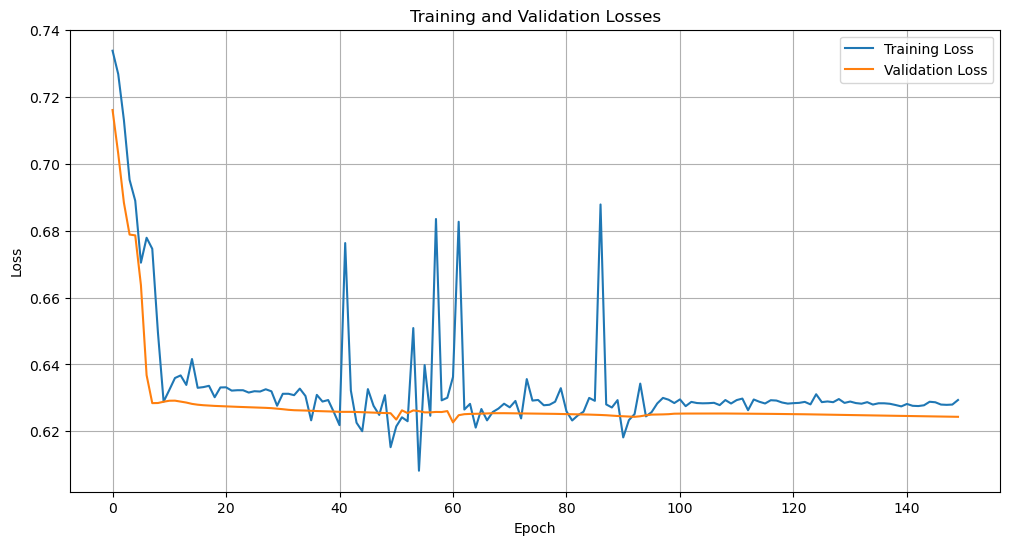

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# Lists to store losses for plotting
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass (training)
    h_dict = model(g)
    drug_embed = h_dict['drug'][train_u]
    indication_embed = h_dict['indication'][train_v]
    
    predictions = link_prediction_model(drug_embed, indication_embed).squeeze()
    
    # Calculate BCE loss
    bce_loss = criterion(predictions, train_labels)
    
    # Calculate L2 regularization loss
    l2_reg = torch.tensor(0.)  # Initialize regularization loss
    for param in model.parameters():
        l2_reg += torch.norm(param)  # Calculate L2 norm of parameters
    l2_loss = weight_decay * l2_reg
    
    # Combine BCE loss and L2 regularization loss
    total_loss = bce_loss + l2_loss
    train_losses.append(total_loss.item())
    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        h_dict_valid = model(g)
        valid_drug_embed = h_dict_valid['drug'][val_u]
        valid_indication_embed = h_dict_valid['indication'][val_v]
        valid_predictions = link_prediction_model(valid_drug_embed, valid_indication_embed).squeeze()
        valid_loss = criterion(valid_predictions, val_labels)
        valid_losses.append(valid_loss.item())
    # Print training and validation losses every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss {total_loss.item():.4f}, Validation Loss {valid_loss.item():.4f}')
        scheduler.step()
# Plotting the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def create_results_df(relationship_type, h_dict_sample, link_prediction_model, sample_u, sample_v, nodes_dictionary, sample_labels):
    """Create a DataFrame with prediction results based on relationship type."""

    if relationship_type == 'NEWDRUG':
        sample_relationship_embed = h_dict_sample['NEWDRUG'][sample_v]
        node_key = 'NEWDRUG'
        dict_key = 'NEWDRUG'
    elif relationship_type == 'treat':
        sample_relationship_embed = h_dict_sample['indication'][sample_v]
        node_key = 'Indication_ID'
        dict_key = 'indication'
    else:
        raise ValueError("Invalid relationship type provided!")
        
    sample_predictions = link_prediction_model(sample_drug_embed, sample_relationship_embed).squeeze()

    # Create a DataFrame to store the results.
    results_df = pd.DataFrame({
        'Drug_ID': [nodes_dictionary['drug'][u.item()] for u in sample_u],
        node_key: [nodes_dictionary[dict_key][v.item()] for v in sample_v],
        'True_Labels': sample_labels.tolist(),
        'Predictions': sample_predictions.tolist()
    })
    return results_df

In [16]:
import torch
from sklearn.metrics import roc_curve, roc_auc_score


true_labels = torch.zeros(len(train_u))
true_labels[:len(pos_u)] = 1  # Set positive samples to 1

with torch.no_grad():
    h_dict = model(g)
    test_drug_embed = h_dict['drug'][train_u]
    test_indication_embed = h_dict['indication'][train_v]

    # Predict link probabilities
    test_predictions = link_prediction_model(test_drug_embed, test_indication_embed).squeeze()

    # Convert probabilities to binary predictions
    predicted_labels = (test_predictions > 0.5).float()

    # Calculate sample_labels
    sample_labels = true_labels.detach().numpy()
    sample_predictions = test_predictions.detach().numpy()

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(sample_labels, sample_predictions)
    print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.5018609087766497


In [ ]:
# Compute the ROC curve
fpr, tpr, _ = roc_curve(sample_labels, sample_predictions)

# Compute AUC
roc_auc = roc_auc_score(sample_labels, sample_predictions)

plt.figure(figsize=(10, 7))

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve HeteroGCN (AUC = {roc_auc:.2f})', color='#FF69B4')

# Plot the diagonal line (represents random classifier)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd

# Assuming your function create_results_df is as you've defined

# Invoke the function to get the DataFrame
results_df = create_results_df(relationship_type, h_dict_sample, link_prediction_model, sample_u, sample_v, nodes_dictionary, sample_labels)

# Save DataFrame to CSV
file_name = "results.csv"
results_df.to_csv(file_name, index=False)
print(f"Results saved to {file_name}")